In [1]:
import math, os, time
from tqdm import tqdm
import gc
import pickle
import random
import datetime
import operator
import numpy as np
import pandas as pd
import warnings
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
import faiss

warnings.filterwarnings('ignore')

# 1. 数据导入、数据分割

In [2]:
data_path = '../datasets/newrec_data_tianchi/'
save_path = '.'
os.path.exists(data_path), os.path.isdir(data_path)

(True, True)

In [5]:
train_all_clicks = pd.read_csv(os.path.join(data_path, 'train_click_log.csv'))
train_all_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              1112623 non-null  int64
 1   click_article_id     1112623 non-null  int64
 2   click_timestamp      1112623 non-null  int64
 3   click_environment    1112623 non-null  int64
 4   click_deviceGroup    1112623 non-null  int64
 5   click_os             1112623 non-null  int64
 6   click_country        1112623 non-null  int64
 7   click_region         1112623 non-null  int64
 8   click_referrer_type  1112623 non-null  int64
dtypes: int64(9)
memory usage: 76.4 MB


In [7]:
train_all_clicks.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,199999,160417,1507029570190,4,1,17,1,13,1
1,199999,5408,1507029571478,4,1,17,1,13,1
2,199999,50823,1507029601478,4,1,17,1,13,1
3,199998,157770,1507029532200,4,1,17,1,25,5
4,199998,96613,1507029671831,4,1,17,1,25,5


In [8]:
train_all_clicks.columns, train_all_clicks.index

(Index(['user_id', 'click_article_id', 'click_timestamp', 'click_environment',
        'click_deviceGroup', 'click_os', 'click_country', 'click_region',
        'click_referrer_type'],
       dtype='object'),
 RangeIndex(start=0, stop=1112623, step=1))

In [9]:
train_all_clicks.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'], inplace=True)
train_all_clicks.shape

(1112623, 9)

In [11]:
user_ids = train_all_clicks['user_id'].unique()[::-1]
num_data = train_all_clicks.shape[0]
num_users = user_ids.shape[0]
num_data, num_users, num_samples

(1112623, 200000, 40000)

In [12]:
# val_users = np.random.choice(user_ids, size=num_samples, replace=False)
# train_all_clicks = all_clicks[~all_clicks['user_id'].isin(val_users)]
# val_all_clicks = all_clicks[all_clicks['user_id'].isin(val_users)]

test_all_clicks = pd.read_csv(os.path.join(data_path, 'testA_click_log.csv'))
test_all_clicks.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'], inplace=True)

all_clicks = train_all_clicks.append(test_all_clicks)
all_clicks.shape

(1630633, 9)

In [62]:
# 获取所有的用户ID
user_ids = np.sort(all_clicks['user_id'].unique())

# 2. ItemCF操作

只利用**用户ID、文章ID、点击时间**三个特征进行预测，采用最传统协同过滤中的ItemCF进行处理。

In [17]:
# 建立倒排表
def create_user_item_time_dict(df):
    click_df = df.sort_values(by='click_timestamp')
    click_df = click_df.groupby('user_id')

    click_df = click_df['click_article_id', 'click_timestamp'].apply(lambda df: list(zip(df['click_article_id'], df['click_timestamp'])))
    click_df = click_df.reset_index().rename(columns={0: 'item_time_list'})

    user_item_time_dict = dict(zip(click_df['user_id'], click_df['item_time_list']))
    
    pickle.dump(user_item_time_dict, open(os.path.join(save_path, 'user_item_time_dict.pkl'), 'wb'))
    print('{:=^40}'.format('用户-物品、时间倒排表生成结束，已写入到离线文件！'))
    return user_item_time_dict

In [16]:
# 计算商品间相似度矩阵
def cal_item_item_sim(df, user_item_time_dict):
    item_item_sim = {}
    item_counts = collections.defaultdict(int)
    
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        for item, time in item_time_list:
            item_counts[item] += 1
            item_item_sim.setdefault(item, {})
            for other_item, other_item_time in item_time_list:
                if item == other_item:
                    continue
                item_item_sim[item].setdefault(other_item, 0)
                item_item_sim[item][other_item] += 1

    for item, sim_items in tqdm(item_item_sim.items()):
        for other_item, coo_counts in sim_items.items():
            item_item_sim[item][other_item] /= math.sqrt(item_counts[item] * item_counts[other_item])
            
    pickle.dump(item_item_sim, open(os.path.join(save_path, 'item_item_similarity.pkl'), 'wb'))
    print('{:=^40}'.format('物品相似度矩阵计算成功，已写入到离线文件！'))
    return item_item_sim

In [18]:
user_item_time_dict = create_user_item_time_dict(all_clicks)
item_item_sim = cal_item_item_sim(all_clicks, user_item_time_dict)

  9%|▉         | 22501/250000 [00:00<00:01, 218586.00it/s]

=======用户-物品、时间倒排表生成结束，已写入到离线文件！========


100%|██████████| 35380/35380 [00:03<00:00, 9070.25it/s] 


=========物品相似度矩阵计算成功，已写入到离线文件！==========


In [19]:
# TopK热门商品
def hot_k_items(df, top_k):
    return df['click_article_id'].value_counts().index[:top_k]

In [20]:
# 基于ItemCF的商品推荐
def itemcf_rec(user_id, recall_top_k, sim_top_k, user_item_time_dict, item_item_sim, hot_top_k_items):
    user_clicked_items_with_time = user_item_time_dict[user_id]
    user_clicked_items = {item_id for item_id, _ in user_clicked_items_with_time}
    
    ranked_items = {}
    # 计算未点击过商品的权重，计算方式为：与物品I的相似度 * 物品I被点击的次数
    for index, (item, click_time) in enumerate(user_clicked_items_with_time):
        for other_item, sim in sorted(item_item_sim[item].items(), 
                                      key=lambda x: x[1], 
                                      reverse=True)[:sim_top_k]:
            if other_item not in user_clicked_items:
                ranked_items.setdefault(other_item, 0)
                ranked_items[other_item] += sim
    
    # 不足需要召回的数量，用热门商品填充
    if len(ranked_items) < recall_top_k:
        for index, item in enumerate(hot_top_k_items):
            if item not in ranked_items:
                ranked_items[item] = -index
            if len(ranked_items) == recall_top_k:
                break
    
    return sorted(ranked_items.items(), key=lambda x:x[1], reverse=True)[:recall_top_k]

In [67]:
def create_all_user_recall_items(user_ids, user_item_time_dict=None, item_item_sim=None):
    if not user_item_time_dict:
        user_item_time_dict = pickle.load(open(os.path.join(save_path, 'user_item_time_dict.pkl'), 'rb'))
    if not item_item_sim:
        item_item_sim = pickle.load(open(os.path.join(save_path, 'item_item_similarity.pkl'), 'rb'))

    sim_top_k = 10
    recall_top_k = 10
    hot_top_k_items = hot_k_items(all_clicks, 50)

    user_recall_items_dict = collections.defaultdict(dict)
    for user in tqdm(user_ids):
        user_recall_items_dict[user] = itemcf_rec(
            user, recall_top_k, sim_top_k, user_item_time_dict, 
            item_item_sim, hot_top_k_items)
    pickle.dump(user_recall_items_dict, open(os.path.join(save_path, 'user_recall_items_dict.pkl'), 'wb'))
    print('{:=^40}'.format('全用户的物品召回推荐计算成功，已写入到离线文件！'))
# create_all_user_recall_items(user_ids)

100%|██████████| 250000/250000 [34:28<00:00, 120.86it/s]


========全用户的物品召回推荐计算成功，已写入到离线文件！========


In [37]:
test_recall_list = []
for user in test_users:
    top_k_items = [item for item, _ in test_user_recall_items_dict[user]][:5]
    test_recall_list.append((user, *top_k_items))
test_recall_df = pd.DataFrame(test_recall_list, 
                              columns=['user_id','article_1','article_2','article_3','article_4','article_5'])
save_file(test_recall_df, save_path, 'itemcf')

# 3. 数据分析

对数据特征、特征含义进行了解

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

In [84]:
articles = pd.read_csv(os.path.join(data_path, 'articles.csv'))
articles_embedding = pd.read_csv(os.path.join(data_path, 'articles_emb.csv'))
articles.info(), articles_embedding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   words_count    364047 non-null  int64
dtypes: int64(4)
memory usage: 11.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 251 entries, article_id to emb_249
dtypes: float64(250), int64(1)
memory usage: 697.1 MB


(None, None)

In [97]:
# articles_embedding确实占内存有点大，有近700M，调整一下数据类型，节省内存，降到了174M
articles_embedding['article_id'] = articles_embedding['article_id'].astype(np.int16)
articles_embedding.iloc[:, 1:] = articles_embedding.iloc[:, 1:].astype(np.float16)
articles_embedding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 251 entries, article_id to emb_249
dtypes: float16(250), int16(1)
memory usage: 174.3 MB


目前数据以全部导入，共四个文件：
- train_click_log.csv
- testA_click_log.csv
- articles.csv
- articles_emb.csv

导入后目前已有数据：
- all_clicks.  将训练数据和测试数据结合到了一起
- train_all_clicks
- test_all_clicks
- articles
- articles_embedding.  250维

In [100]:
all_clicks.shape, train_all_clicks.shape, test_all_clicks.shape, articles.shape, articles_embedding.shape

((1630633, 9), (1112623, 9), (518010, 9), (364047, 4), (364047, 251))

## 3.1 预处理

计算用户每次点击是第多少次点击，并计算各用户的点击次数

In [127]:
# 添加特征rank，表示是该用户第多少次点击
train_all_clicks['rank'] = train_all_clicks.groupby(
    ['user_id'])['click_timestamp'].rank(ascending=True).astype(np.int)
test_all_clicks['rank'] = test_all_clicks.groupby(
    ['user_id'])['click_timestamp'].rank(ascending=True).astype(np.int)

In [128]:
# 添加特征click_counts，计算用户点击文章的总次数
train_all_clicks['click_counts'] = train_all_clicks.groupby(
    ['user_id'])['click_timestamp'].transform('count')
test_all_clicks['click_counts'] = test_all_clicks.groupby(
    ['user_id'])['click_timestamp'].transform('count')

In [147]:
# 按照 文章名 连接articles中的特征：category_id, created_at_ts, words_count
train_all_clicks =  train_all_clicks.merge(articles, 
                                           how='left', 
                                           left_on='click_article_id', 
                                           right_on='article_id')
test_all_clicks = test_all_clicks.merge(articles, how='left', 
                                       left_on='click_article_id', 
                                        right_on='article_id')
# 由于合并时两个表分别根据的字段是 click_article_id, article_id，
# 导致合并后多出 article_id，需要进行删除
train_all_clicks.drop('article_id', axis=1, inplace=True)
test_all_clicks.drop('article_id', axis=1, inplace=True)

In [159]:
# 查看点击次数
# 训练集中 最少是2次，最多是241次，平均点击13.2次

train_all_clicks['click_counts'].describe()

count    1.112623e+06
mean     1.323704e+01
std      1.631503e+01
min      2.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.600000e+01
max      2.410000e+02
Name: click_counts, dtype: float64

In [158]:
# 查看点击次数
# 测试集中 最少是1次，最多是938次，平均是30次
test_all_clicks['click_counts'].describe()

count    518010.000000
mean         30.043586
std          56.868021
min           1.000000
25%          10.000000
50%          19.000000
75%          35.000000
max         938.000000
Name: click_counts, dtype: float64

<Figure size 432x288 with 0 Axes>

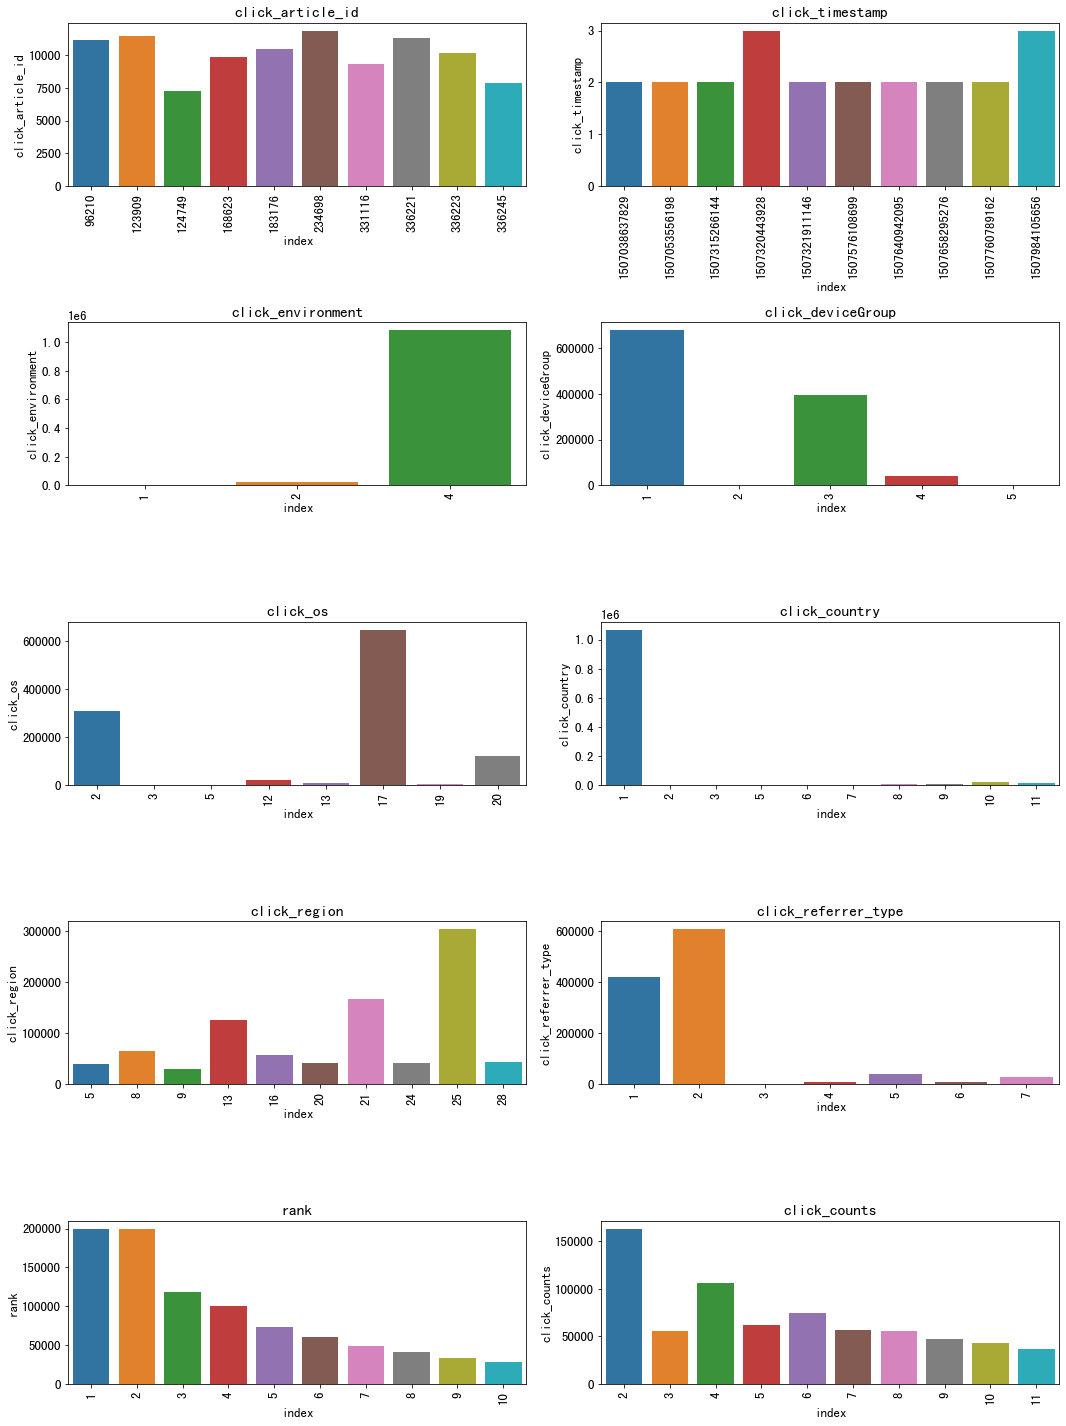

In [163]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_counts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = train_all_clicks[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [169]:
articles_embedding.shape

(364047, 251)

In [175]:
all_clicks = train_all_clicks.append(
    test_all_clicks).sort_values(by='click_timestamp')

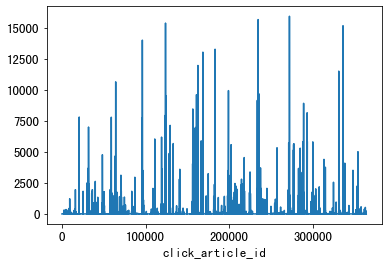

In [192]:
all_clicks.groupby(by='click_article_id')['click_counts'].count().plot()

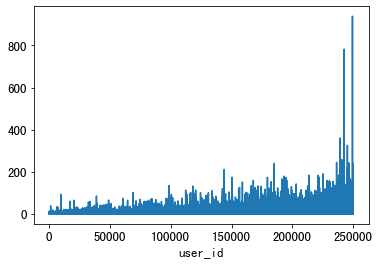

In [193]:
all_clicks.groupby(by='user_id')['click_counts'].count().plot()

# 4. 多路召回

构造三种模式：
1. **Debug模式**。在训练集中分割出少量数据，构造验证集用于调式
2. **线下验证模式**。使用训练集训练出模型，通过测试集进行评估，调整参数、超参数
3. **线上提交模式**。使用所有的数据在选择的模型上进行训练，然后提交线上

----

**由于内存爆了导致内核重启，下面代码重新进行的运行**

----

## 4.1 数据读取、处理、功能性函数构建

In [3]:
# Debug模式
def get_debug_data(data_path, sample_nums=10000):
    all_clicks = pd.read_csv(os.path.join(data_path, 'train_click_log.csv'))
    all_user_ids = all_clicks['user_id'].unique()

    sampled_users = np.random.choice(all_user_ids, size=sample_nums, replace=False)
    all_clicks = all_clicks[all_clicks['user_id'].isin(sampled_users)]
    
    all_clicks = all_clicks.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'])
    return all_clicks

# 线下或线上模式
def get_all_data(data_path, offline=False):
    if offline:
        all_clicks = pd.read_csv(os.path.join(data_path, 'train_click_log.csv'))
    else:
        train_clicks = pd.read_csv(os.path.join(data_path, 'train_click_log.csv'))
        test_clicks = pd.read_csv(os.path.join(data_path, 'testA_click_log.csv'))
        
        all_clicks = train_clicks.append(test_clicks)
        
    all_clicks = all_clicks.drop_duplicates(['user_id', 'click_article_id', 'click_timestamp'])
    return all_clicks

In [4]:
# 读取文章基本属性
def get_item_info(data_path):
    item_info = pd.read_csv(os.path.join(data_path, 'articles.csv'))
    item_info.rename(columns={'article_id': 'click_article_id'}, inplace=True)
    
    return item_info

In [5]:
# 根据article_id，获取Embedding
def get_embedding_by_id(item_embedding, article_id):
    return item_embedding[item_embedding['article_id']==article_id].iloc[:, 1:].values.reshape(-1)

In [6]:
# 导入全量数据（离线），并对时间戳归一化
all_clicks = get_all_data(data_path, offline=False)
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
all_clicks['click_timestamp'] = min_max_scaler.fit_transform(all_clicks[['click_timestamp']])

In [7]:
# 导入文章信息
item_info = get_item_info(data_path)

In [8]:
# 导入文章Embedding数据
item_embedding = pd.read_csv(os.path.join(data_path, 'articles_emb.csv'))
item_embedding['article_id'] = item_embedding['article_id'].astype(np.int32)
item_embedding.iloc[:, 1:] = item_embedding.iloc[:, 1:].astype(np.float32)

In [9]:
# 构造 {用户：[(物品，时间), (物品，时间)]} 格式的字典，用于物品协同过滤
def get_user_item_time_dict(df):
    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))
    
    df = df.sort_values('click_timestamp')
    user_item_time_df = df.groupby('user_id')[
        'click_article_id', 'click_timestamp'].apply(
        lambda x: make_item_time_pair(x)).reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))
    
    return user_item_time_dict
# 经过测试，功能正常

In [10]:
# 构造 {文章：[(用户，时间), (用户，时间)]} 格式的字典，用于用户协同过滤
def get_item_user_time_dict(df):
    def make_user_time_pair(df):
        return list(zip(df['user_id'], df['click_timestamp']))
    
    df = df.sort_values('click_timestamp')
    item_user_time_df = df.groupby('click_article_id')[
        'user_id', 'click_timestamp'].apply(
        lambda x:make_user_time_pair(x)).reset_index().rename(columns={0: 'user_time_list'})
    item_user_time_dict = dict(zip(item_user_time_df['click_article_id'], item_user_time_df['user_time_list']))
    return item_user_time_dict
# 经过测试，功能正常

In [11]:
# 获取当前数据的历史点击和最后一次点击
def get_hist_and_last_click(df):
    df = df.sort_values(by=['user_id', 'click_timestamp'])
    # 筛选出最后一个点击记录
    click_last_df = df.groupby(by='user_id').tail(1)
    
    # 如果用户只有一个点击，hist为空了，会导致训练的时候这个用户不可见，此时默认泄露一下
    def hist_func(df):
        if (len(df) == 1):
            return df
        else:
            return df[:-1]
    
    click_hist_df = df.groupby(by='user_id').apply(hist_func).reset_index(drop=True)
    return click_hist_df, click_last_df
# 经过测试，功能正常

In [12]:
# 获取近期点击最多的前K个文章
def get_topk_clicked_items(df, k):
    return df['click_article_id'].value_counts().index[:k]
# 经过测试，功能正常

In [13]:
all_clicks['click_article_id'].unique().shape

(35380,)

## 4.2 多路召回的相似性计算

包括：
- usercf
- itemcf
- embedding
- youtube nn
- cold start

### 4.2.1 usercf

基于用户的协同过滤，思想是给用户推荐相似用户喜欢的物品（自己未交互过的）

流程：
- 构建 **用户-用户** 相似度矩阵（余弦相似度，共同喜欢的物品除以各个的规范项）
- 基于相似度矩阵选择相似用户进行推荐

此处相似度计算加上了用户活跃度的权重

In [14]:
# 构造用户活跃度，活跃度取值为归一化的新闻点击次数
def get_user_activate_degree(df):
    click_counts = df.groupby('user_id')['click_article_id'].count().reset_index()
    
    min_max_scaler = MinMaxScaler()
    click_counts['activate_w'] = min_max_scaler.fit_transform(click_counts[['click_article_id']])
    
    user_counts = dict(zip(click_counts['user_id'], click_counts['click_article_id']))
    user_activate_degree = dict(zip(click_counts['user_id'], click_counts['activate_w']))
    
    return user_counts, user_activate_degree


# 计算usercf中的用户相似度矩阵
def usercf_user2user_sim(df):
    item_user_time_dict = get_item_user_time_dict(df)
    user_counts, user_activate_degree = get_user_activate_degree(df)
    
    u2u_sim = {}
    for item, user_time_list in tqdm(item_user_time_dict.items()):
        for u, click_time in user_time_list:
            u2u_sim.setdefault(u, {})
            for v, click_time in user_time_list:
                u2u_sim[u].setdefault(v, 0)
                if u == v:
                    continue
                # 用户平均活跃度作为活跃度的权重
                activate_w = 100 * 0.5 * (user_activate_degree[u] + user_activate_degree[v])
                u2u_sim[u][v] += activate_w / math.log(len(user_time_list) + 1)
    for u, related_users in u2u_sim.items():
        for v in related_users.keys():
            u2u_sim[u][v] /= math.sqrt(user_counts[u] + user_counts[v])
            
    # 存储到本地
    pickle.dump(u2u_sim, open(os.path.join(save_path, 'usercf_u2u_sim.pkl'), 'wb'))
    
    return u2u_sim

'''
代码无误，但全用户下计算太慢，而且会导致内存溢出。
而item相似度矩阵不会，因为item相似度中的item数量是35380，其它item都为被点击
如果要计算用户相似度矩阵，应该进行活跃度筛选，以降低用户数量
'''

'\n代码无误，但全用户下计算太慢，而且会导致内存溢出。\n而item相似度矩阵不会，因为item相似度中的item数量是35380，其它item都为被点击\n如果要计算用户相似度矩阵，应该进行活跃度筛选，以降低用户数量\n'

### 4.2.2 itemcf

前面虽然已经进行了实现，但使用的是最基本的余弦相似度，只是构建一个baseline。

再次计算item2item相似度时，引入了一些其它的优化:
- 位置间隔权重 loc_weight
- 点击间隔时间权重 click_time_weight
- 创建时间间隔权重 created_time_weight
- 流行度惩罚 N

相似度计算公式为：
$$
sim = \sum \frac{LocWeight * ClickTimeWeight * CreatedTimeWeight}{\log(N+1)\sqrt{|N(i)||N(j)|}}
$$

In [15]:
# 计算itemcf中的物品相似度矩阵，采用协同过滤+关联规则
def itemcf_item2item_sim(df):
    # 获取倒排表
    user_item_time_dict = get_user_item_time_dict(df)
    # 计算物品出现次数，以Series形式存储
    item_counts = df['click_article_id'].value_counts()
    # 计算物品创建时间，以Series形式存储
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    item_created_time = item_info[['created_at_ts']].apply(max_min_scaler)['created_at_ts']
    # 计算物品相似度
    i2i_sim = {}
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        for loc1, (item, item_click_time) in enumerate(item_time_list):
            i2i_sim.setdefault(item, {})
            for loc2, (item_, item__click_time) in enumerate(item_time_list):
                if item == item_:
                    continue
                
                loc_alpha = 1.0 if loc2 > loc1 else 0.7
                loc_weight = loc_alpha * (0.9 ** (np.abs(loc2 - loc1) - 1))
                click_time_weight = np.exp(0.7 ** np.abs(item_click_time - item__click_time))
                created_time_weight = np.exp(0.8 ** np.abs(item_created_time[item] - item_created_time[item_]))
                i2i_sim[item].setdefault(item_, 0)
                i2i_sim[item][item_] += loc_weight * click_time_weight * created_time_weight / math.log(len(item_time_list) + 1)
    for i, related_items in i2i_sim.items():
        for j, w_ij in related_items.items():
            i2i_sim[i][j] /= math.sqrt(item_counts[i] * item_counts[j])
    
    pickle.dump(i2i_sim, open(os.path.join(save_path, 'itemcf_item2item_sim.pkl'), 'wb'))
    print('{:=^40}'.format('全用户的物品相似度矩阵计算成功，并已写入到离线文件！'))
    return i2i_sim


### 4.2.3 embedding

通过物品的Embedding计算物品（文章）之间的相似度，因为点击数据中相似度仅仅只有活跃物品，共35380个，而实际物品数量是364047个，存在大量物品未被点击，而这些是可能被点击到的。

通过embedding相似度计算，可以找到相似、但从未被点击的物品（冷启动物品）

In [16]:
item_embedding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 251 entries, article_id to emb_249
dtypes: float32(250), int32(1)
memory usage: 348.6 MB


In [81]:
def get_embedding_sim(df, item_embedding, topk=10):
    """
        基于内容的文章embedding相似性矩阵计算
        :param df: 数据表
        :param item_emb_df: 文章的embedding
        :param save_path: 保存路径
        :patam topk: 找最相似的topk篇
        return 文章相似性矩阵
        
        思路: 对于每一篇文章， 基于embedding的相似性返回topk个与其最相似的文章， 只不过由于文章数量太多，这里用了faiss进行加速
    """
    # 构建索引与文章的映射
    item_index2_raw_id_dict = dict(zip(item_embedding.index, item_embedding['article_id']))
    
    item_embedding_cols = [x for x in item_embedding.columns if 'emb' in x]
    item_embedding_np = np.ascontiguousarray(item_embedding[item_embedding_cols].values, dtype=np.float32)
    item_embedding_np = item_embedding_np / np.linalg.norm(item_embedding_np, axis=1, keepdims=True)
    
    # 建立faiss索引
    item_index = faiss.IndexFlatIP(item_embedding_np.shape[1])
    item_index.add(item_embedding_np)
    # 相似度查询，给每个索引位置的向量返回topk个item以及相似度 (返回的是列表)
    sim, idx = item_index.search(item_embedding_np, topk+1)
    
    # 将向量检索的结果保存成原始id的对应关系
    item_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(item_embedding_np)), sim, idx)):
        target_raw_id = item_index2_raw_id_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_index2_raw_id_dict[rele_idx]
            item_sim_dict[target_raw_id][rele_raw_id] = item_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(item_sim_dict, open(os.path.join(save_path, 'emb_i2i_sim.pkl'), 'wb'))   
    print('{:=^40}'.format('全用户的物品embedding相似度矩阵计算成功，并已写入到离线文件！'))
    return item_sim_dict

In [82]:
embedding_i2i_sim = get_embedding_sim(all_clicks, item_embedding)

364047it [00:13, 26788.68it/s]


==全用户的物品embedding相似度矩阵计算成功，并已写入到离线文件！===


In [83]:
embedding_i2i_sim[2]

{3782: 0.8811300992965698,
 3795: 0.8786486983299255,
 2903: 0.875537097454071,
 2038: 0.8748056292533875,
 3193: 0.8691880702972412,
 1967: 0.8674073219299316,
 3807: 0.865835964679718,
 3202: 0.8636599183082581,
 3428: 0.8607038259506226,
 4325: 0.8587755560874939}

## 4.3 构建多路召回字典

定义多路召回字典，将各路召回结果都放在里面

In [18]:
multi_item_recall_dict = {'itemcf_sim_recall': {},
                    'embedding_sim_recall': {},
                    'youtubednn_recall': {},
                    'youtubednn_usercf_recall': {},
                    'cold_start_recall': {}}

### 4.3.1 itemcf召回

In [19]:
# itemcf根据user召回items
def item_based_recommend(user_id, sim_item_topk, recall_item_num, 
                         user_item_time_dict, i2i_sim, 
                         item_topk_click, item_created_time, embedding_i2i_sim):
    """
    基于文章协同过滤的召回
    :param user_id: 用户id
    :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
    :param i2i_sim: 字典，文章相似性矩阵
    :param sim_item_topk: 整数， 选择与当前文章最相似的前k篇文章
    :param recall_item_num: 整数， 最后的召回文章数量
    :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
    :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵

    return: 召回的文章列表 [(item1, score1), (item2, score2)...]
    """
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}
    
    item_rank = {}
    for loc, (item_u, click_time) in enumerate(user_hist_items):
        for item_v, w_ij in sorted(i2i_sim[item_u].items(), 
                                   key=lambda x: x[1], reverse=True)[: sim_item_topk]:
            if item_v in user_hist_items_:
                continue
            # 创建文章时间差权重
            created_time_weight = np.exp(0.8 ** np.abs(item_created_time[item_u] - item_created_time[item_v]))
            # 相似文章和历史点击文章序列中文章所在的位置权重
            loc_weight = 0.9 ** (len(user_hist_items) - loc)
            
            content_weight = 1.0
            if embedding_i2i_sim.get(item_u, {}).get(item_v, None) is not None:
                content_weight += embedding_i2i_sim[item_u][item_v]
            if embedding_i2i_sim.get(item_v, {}).get(item_u, None) is not None:
                content_weight += embedding_i2i_sim[item_v][item_u]
            
            item_rank.setdefault(item_v, 0)
            item_rank[item_v] += created_time_weight * loc_weight * content_weight * w_ij
    
    # 不足个数，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank.items():
                continue
            item_rank[item] = -i
            if len(item_rank) == recall_item_num:
                break
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[: recall_item_num]
    return item_rank

----

**导入数据，开始召回**

----

In [20]:
user_item_time_dict = get_user_item_time_dict(all_clicks)
max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
item_created_time = item_info[['created_at_ts']].apply(max_min_scaler)['created_at_ts']
topk_clicked_items = get_topk_clicked_items(all_clicks, 20)
i2i_sim = pickle.load(open(os.path.join(save_path, 'itemcf_item2item_sim.pkl'), 'rb'))
embedding_i2i_sim = pickle.load(open(os.path.join(save_path, 'emb_i2i_sim.pkl'), 'rb'))
sim_item_topk = 20
recall_item_num = 10

In [21]:
# 召回所有用户的items
def recall_itemcf_items():
    train_hist_clicks, train_last_click = get_hist_and_last_click(all_clicks)
    user_recall_items_dict = collections.defaultdict(dict)

    user_item_time_dict = get_user_item_time_dict(train_hist_clicks)
    sim_item_topk = 20
    recall_item_num = 10
    topk_clicked_items = get_topk_clicked_items(train_hist_clicks, k=50)

    for user in tqdm(train_hist_clicks['user_id'].unique()):
        user_recall_items_dict[user] = item_based_recommend(user, sim_item_topk, recall_item_num, user_item_time_dict, i2i_sim, topk_clicked_items, item_created_time, embedding_i2i_sim)

    multi_item_recall_dict['itemcf_sim_recall'] = user_recall_items_dict
    pickle.dump(user_recall_items_dict, open(os.path.join(save_path, 'itemcf_recall_dict.pkl'), 'wb'))

100%|██████████| 250000/250000 [1:07:26<00:00, 61.79it/s]


In [29]:
item_based_recommend(10, 10, 5, user_item_time_dict, i2i_sim, None, item_created_time, embedding_i2i_sim)

[(36162, 1.7879178848767796),
 (211442, 1.0236542288113257),
 (209122, 0.9643052935207357),
 (156279, 0.8202088277258655),
 (70986, 0.7307442352120328)]

In [55]:
def save_file(df, save_path, model):
    save_name = os.path.join(save_path, model + '_' + datetime.datetime.today().strftime('%y-%m-%d') + '.csv')
    df.to_csv(save_name, index=False, header=True)

In [58]:
# 输出用于提交线上测试的csv数据
def test_items_predict(recall_dict, topk=5):
    test_recall_list = []
    test_clicks = pd.read_csv(os.path.join(data_path, 'testA_click_log.csv'))
    for user in tqdm(test_clicks['user_id'].unique()):
        top_k_items = [item for item, _ in recall_dict[user]][:topk]
    #     top_k_items = [item for item, _ in item_based_recommend(user, 10, 5, user_item_time_dict, i2i_sim, topk_clicked_items, item_created_time, embedding_i2i_sim)]
        test_recall_list.append((user, *top_k_items))
    test_recall_df = pd.DataFrame(test_recall_list, 
                                  columns=['user_id','article_1','article_2','article_3','article_4','article_5'])
    save_file(test_recall_df, save_path, 'itemcf')

### 4.3.2 embedding sim召回

In [78]:
embedding_i2i_sim[0]

{77608: 0.8903070688247681,
 77965: 0.8881016969680786,
 77610: 0.8859948515892029,
 77974: 0.8822700381278992,
 83769: 0.8771183490753174,
 77383: 0.8734965920448303,
 77296: 0.8730965852737427,
 77283: 0.8729653358459473,
 77978: 0.8696216940879822}

In [208]:
# 直接根据embedding内容根据用户id进行召回，即前面计算的Embedding相似度，
def embedding_bases_recommend(user_id, user_item_time_dict, embedding_i2i_sim, 
                              sim_item_topk, recall_item_num, item_topk_click):
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}
    
    item_rank = {}
    for loc, (item_u, click_time) in enumerate(user_hist_items):
        for item_v, w_ij in sorted(embedding_i2i_sim[item_u].items(), 
                                   key=lambda x: x[1], reverse=True)[: sim_item_topk]:
            if item_v in user_hist_items_:
                continue     
            item_rank.setdefault(item_v, 0)
            item_rank[item_v] += w_ij
    
    # 不足个数，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank.items():
                continue
            item_rank[item] = -i
            if len(item_rank) == recall_item_num:
                break
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[: recall_item_num]
    return item_rank

def recall_itemembedding_items(embedding_i2i_sim, sim_item_topk=20, recall_item_num=10):
    train_hist_clicks, train_last_click = get_hist_and_last_click(all_clicks)
    user_recall_items_dict = collections.defaultdict(dict)

    user_item_time_dict = get_user_item_time_dict(train_hist_clicks)

    topk_clicked_items = get_topk_clicked_items(train_hist_clicks, k=50)

    for user in tqdm(train_hist_clicks['user_id'].unique()):
        user_recall_items_dict[user] = embedding_bases_recommend(user, user_item_time_dict,
                                                                 embedding_i2i_sim, sim_item_topk, 
                                                                 recall_item_num, topk_clicked_items)
    multi_item_recall_dict['embedding_sim_recall'] = user_recall_items_dict
    pickle.dump(user_recall_items_dict, open(os.path.join(save_path, 'embedding_recall_dict.pkl'), 'wb'))
    print('{:=^40}'.format('基于embedding的物品召回计算成功，并已写入到离线文件！'))

In [217]:
recall_itemembedding_items(embedding_i2i_sim)

100%|██████████| 250000/250000 [00:15<00:00, 15816.99it/s]


====基于embedding的物品召回计算成功，并已写入到离线文件！=====


### 4.3.3 youtube模型与召回

In [91]:
multi_item_recall_dict.keys()

dict_keys(['itemcf_sim_recall', 'embeddingg_sim_recall', 'cold_start_recall', 'embedding_sim_recall', 'youtubednn_recall'])

In [100]:
from deepmatch.models import *
from deepmatch.utils import sampledsoftmaxloss
from sklearn.preprocessing import LabelEncoder
from deepctr.feature_column import SparseFeat, VarLenSparseFeat
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [101]:
import random
# 获取双塔召回时的训练验证数据
# negsample指的是通过滑窗构建样本的时候，负样本的数量
def gen_data_set(data, negsample=0):
    data.sort_values("click_timestamp", inplace=True)
    item_ids = data['click_article_id'].unique()

    train_set = []
    test_set = []
    for reviewerID, hist in tqdm(data.groupby('user_id')):
        pos_list = hist['click_article_id'].tolist()
        
        if negsample > 0:
            candidate_set = list(set(item_ids) - set(pos_list))   # 用户没看过的文章里面选择负样本
            neg_list = np.random.choice(candidate_set,size=len(pos_list)*negsample,replace=True)  # 对于每个正样本，选择n个负样本
            
        # 长度只有一个的时候，需要把这条数据也放到训练集中，不然的话最终学到的embedding就会有缺失
        if len(pos_list) == 1:
            train_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
            test_set.append((reviewerID, [pos_list[0]], pos_list[0],1,len(pos_list)))
            
        # 滑窗构造正负样本
        for i in range(1, len(pos_list)):
            hist = pos_list[:i]
            
            if i != len(pos_list) - 1:
                train_set.append((reviewerID, hist[::-1], pos_list[i], 1, len(hist[::-1])))  # 正样本 [user_id, his_item, pos_item, label, len(his_item)]
                for negi in range(negsample):
                    train_set.append((reviewerID, hist[::-1], neg_list[i*negsample+negi], 0,len(hist[::-1]))) # 负样本 [user_id, his_item, neg_item, label, len(his_item)]
            else:
                # 将最长的那一个序列长度作为测试数据
                test_set.append((reviewerID, hist[::-1], pos_list[i],1,len(hist[::-1])))
                
    random.shuffle(train_set)
    random.shuffle(test_set)
    
    return train_set, test_set

# 将输入的数据进行padding，使得序列特征的长度都一致
def gen_model_input(train_set,user_profile,seq_max_len):

    train_uid = np.array([line[0] for line in train_set])
    train_seq = [line[1] for line in train_set]
    train_iid = np.array([line[2] for line in train_set])
    train_label = np.array([line[3] for line in train_set])
    train_hist_len = np.array([line[4] for line in train_set])

    train_seq_pad = pad_sequences(train_seq, maxlen=seq_max_len, padding='post', truncating='post', value=0)
    train_model_input = {"user_id": train_uid, "click_article_id": train_iid, "hist_article_id": train_seq_pad,
                         "hist_len": train_hist_len}

    return train_model_input, train_label

In [183]:
def youtubednn_u2i_dict(data, topk=10):    
    sparse_features = ["click_article_id", "user_id"]
    SEQ_LEN = 20 # 用户点击序列的长度，短的填充，长的截断
    
    user_profile_ = data[["user_id"]].drop_duplicates('user_id')
    item_profile_ = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    # 类别编码
    features = ["click_article_id", "user_id"]
    feature_max_idx = {}
    
    for feature in features:
        lbe = LabelEncoder()
        data[feature] = lbe.fit_transform(data[feature])
        feature_max_idx[feature] = data[feature].max() + 1
    
    # 提取user和item的画像，这里具体选择哪些特征还需要进一步的分析和考虑
    user_profile = data[["user_id"]].drop_duplicates('user_id')
    item_profile = data[["click_article_id"]].drop_duplicates('click_article_id')  
    
    user_index_2_rawid = dict(zip(user_profile['user_id'], user_profile_['user_id']))
    item_index_2_rawid = dict(zip(item_profile['click_article_id'], item_profile_['click_article_id']))
    
    # 划分训练和测试集
    # 由于深度学习需要的数据量通常都是非常大的，所以为了保证召回的效果，往往会通过滑窗的形式扩充训练样本
    train_set, test_set = gen_data_set(data, 0)
    # 整理输入数据，具体的操作可以看上面的函数
    train_model_input, train_label = gen_model_input(train_set, user_profile, SEQ_LEN)
    test_model_input, test_label = gen_model_input(test_set, user_profile, SEQ_LEN)
    
    # 确定Embedding的维度
    embedding_dim = 16
    
    # 将数据整理成模型可以直接输入的形式
    user_feature_columns = [SparseFeat('user_id', feature_max_idx['user_id'], embedding_dim),
                            VarLenSparseFeat(SparseFeat('hist_article_id', feature_max_idx['click_article_id'], embedding_dim,
                                                        embedding_name="click_article_id"), SEQ_LEN, 'mean', 'hist_len'),]
    item_feature_columns = [SparseFeat('click_article_id', feature_max_idx['click_article_id'], embedding_dim)]
    
    # 模型的定义 
    if tf.__version__ >= '2.0.0':
        tf.compat.v1.disable_eager_execution()
    # num_sampled: 负采样时的样本数量
    model = YoutubeDNN(user_feature_columns, item_feature_columns, num_sampled=5, user_dnn_hidden_units=(64, embedding_dim))
    # 模型编译
    model.compile(optimizer="adam", loss=sampledsoftmaxloss)  
    
    # 模型训练，这里可以定义验证集的比例，如果设置为0的话就是全量数据直接进行训练
    history = model.fit(train_model_input, train_label, batch_size=256, epochs=1, verbose=1, validation_split=0.0)
    
    # 训练完模型之后,提取训练的Embedding，包括user端和item端
    test_user_model_input = test_model_input
    all_item_model_input = {"click_article_id": item_profile['click_article_id'].values}

    user_embedding_model = Model(inputs=model.user_input, outputs=model.user_embedding)
    item_embedding_model = Model(inputs=model.item_input, outputs=model.item_embedding)
    
    # 保存当前的item_embedding 和 user_embedding 排序的时候可能能够用到，但是需要注意保存的时候需要和原始的id对应
    user_embs = user_embedding_model.predict(test_user_model_input, batch_size=2 ** 12)
    item_embs = item_embedding_model.predict(all_item_model_input, batch_size=2 ** 12)
    
    # embedding保存之前归一化一下
    user_embs = user_embs / np.linalg.norm(user_embs, axis=1, keepdims=True)
    item_embs = item_embs / np.linalg.norm(item_embs, axis=1, keepdims=True)
    
    # 将Embedding转换成字典的形式方便查询
    raw_user_id_emb_dict = {user_index_2_rawid[k]: \
                                v for k, v in zip(user_profile['user_id'], user_embs)}
    raw_item_id_emb_dict = {item_index_2_rawid[k]: \
                                v for k, v in zip(item_profile['click_article_id'], item_embs)}
    # 将Embedding保存到本地
    pickle.dump(raw_user_id_emb_dict, open(save_path + 'user_youtube_emb.pkl', 'wb'))
    print('{:=^40}'.format('YoutubeDNN召回模型用户Embedding计算成功，并已写入到离线文件！'))
    pickle.dump(raw_item_id_emb_dict, open(save_path + 'item_youtube_emb.pkl', 'wb'))
    print('{:=^40}'.format('YoutubeDNN召回模型物品Embedding计算成功，并已写入到离线文件！'))
    # faiss紧邻搜索，通过user_embedding 搜索与其相似性最高的topk个item
    index = faiss.IndexFlatIP(embedding_dim)
    # 上面已经进行了归一化，这里可以不进行归一化了
#     faiss.normalize_L2(user_embs)
#     faiss.normalize_L2(item_embs)
    index.add(item_embs) # 将item向量构建索引
    sim, idx = index.search(np.ascontiguousarray(user_embs), topk) # 通过user去查询最相似的topk个item
    
    user_recall_items_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(test_user_model_input['user_id'], sim, idx)):
        target_raw_id = user_index_2_rawid[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = item_index_2_rawid[rele_idx]
            user_recall_items_dict[target_raw_id][rele_raw_id] = user_recall_items_dict.get(target_raw_id, {})\
                                                                    .get(rele_raw_id, 0) + sim_value
            
    user_recall_items_dict = {k: sorted(v.items(), key=lambda x: x[1], reverse=True) for k, v in user_recall_items_dict.items()}
    # 将召回的结果进行排序
    
    # 保存召回的结果
    # 这里是直接通过向量的方式得到了召回结果，相比于上面的召回方法，上面的只是得到了i2i及u2u的相似性矩阵，还需要进行协同过滤召回才能得到召回结果
    # 可以直接对这个召回结果进行评估，为了方便可以统一写一个评估函数对所有的召回结果进行评估
    pickle.dump(user_recall_items_dict, open(save_path + 'youtube_u2i_dict.pkl', 'wb'))
    print('{:=^40}'.format('YoutubeDNN召回结果计算成功，并已写入到离线文件！'))
    
    return user_recall_items_dict

In [184]:
multi_item_recall_dict['youtubednn_recall'] = youtubednn_u2i_dict(train_hist_clicks)

100%|██████████| 250000/250000 [00:54<00:00, 4574.02it/s]


Train on 1077081 samples
1077081/1077081 [==============================] - 185s 172us/sample - loss: 0.1556
YoutubeDNN召回模型用户Embedding计算成功，并已写入到离线文件！
YoutubeDNN召回模型物品Embedding计算成功，并已写入到离线文件！


250000it [00:08, 28968.84it/s]


=====YoutubeDNN召回结果计算成功，并已写入到离线文件！======


### 4.3.4 usercf（youtubednn embedding sim）召回

In [122]:
# 使用Embedding的方式获取u2u的相似性矩阵
# topk指的是每个user, faiss搜索后返回最相似的topk个user
def u2u_embdding_sim(click_df, user_emb_dict, save_path, topk):
    
    user_list = []
    user_emb_list = []
    for user_id, user_emb in user_emb_dict.items():
        user_list.append(user_id)
        user_emb_list.append(user_emb)
        
    user_index_2_rawid_dict = {k: v for k, v in zip(range(len(user_list)), user_list)}    
    
    user_emb_np = np.array(user_emb_list, dtype=np.float32)
    
    # 建立faiss索引
    user_index = faiss.IndexFlatIP(user_emb_np.shape[1])
    user_index.add(user_emb_np)
    # 相似度查询，给每个索引位置上的向量返回topk个item以及相似度
    sim, idx = user_index.search(user_emb_np, topk+1) # 返回的是列表
   
    # 将向量检索的结果保存成原始id的对应关系
    user_sim_dict = collections.defaultdict(dict)
    for target_idx, sim_value_list, rele_idx_list in tqdm(zip(range(len(user_emb_np)), sim, idx)):
        target_raw_id = user_index_2_rawid_dict[target_idx]
        # 从1开始是为了去掉商品本身, 所以最终获得的相似商品只有topk-1
        for rele_idx, sim_value in zip(rele_idx_list[1:], sim_value_list[1:]): 
            rele_raw_id = user_index_2_rawid_dict[rele_idx]
            user_sim_dict[target_raw_id][rele_raw_id] = user_sim_dict.get(target_raw_id, {}).get(rele_raw_id, 0) + sim_value
    
    # 保存i2i相似度矩阵
    pickle.dump(user_sim_dict, open(save_path + 'youtube_u2u_sim.pkl', 'wb'))   
    return user_sim_dict

user_emb_dict = pickle.load(open(save_path + 'user_youtube_emb.pkl', 'rb'))
u2u_sim = u2u_embdding_sim(all_clicks, user_emb_dict, save_path, topk=10)

250000it [00:09, 25311.12it/s]


In [124]:
# 基于用户的召回 u2u2i
def user_based_recommend(user_id, user_item_time_dict, u2u_sim, sim_user_topk, recall_item_num, 
                         item_topk_click, item_created_time_dict, emb_i2i_sim):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param u2u_sim: 字典，文章相似性矩阵
        :param sim_user_topk: 整数， 选择与当前用户最相似的前k个用户
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全
        :param item_created_time_dict: 文章创建时间列表
        :param emb_i2i_sim: 字典基于内容embedding算的文章相似矩阵
        
        return: 召回的文章列表 [(item1, score1), (item2, score2)...]
    """
    # 历史交互
    user_item_time_list = user_item_time_dict[user_id]    #  [(item1, time1), (item2, time2)..]
    user_hist_items = set([i for i, t in user_item_time_list])   # 存在一个用户与某篇文章的多次交互， 这里得去重
    
    items_rank = {}
    for sim_u, wuv in sorted(u2u_sim[user_id].items(), key=lambda x: x[1], reverse=True)[:sim_user_topk]:
        for i, click_time in user_item_time_dict[sim_u]:
            if i in user_hist_items:
                continue
            items_rank.setdefault(i, 0)
            
            loc_weight = 1.0
            content_weight = 1.0
            created_time_weight = 1.0
            
            # 当前文章与该用户看的历史文章进行一个权重交互
            for loc, (j, click_time) in enumerate(user_item_time_list):
                # 点击时的相对位置权重
                loc_weight += 0.9 ** (len(user_item_time_list) - loc)
                # 内容相似性权重
                if emb_i2i_sim.get(i, {}).get(j, None) is not None:
                    content_weight += emb_i2i_sim[i][j]
                if emb_i2i_sim.get(j, {}).get(i, None) is not None:
                    content_weight += emb_i2i_sim[j][i]
                
                # 创建时间差权重
                created_time_weight += np.exp(0.8 * np.abs(item_created_time_dict[i] - item_created_time_dict[j]))
                
            items_rank[i] += loc_weight * content_weight * created_time_weight * wuv
        
    # 热度补全
    if len(items_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in items_rank.items(): # 填充的item应该不在原来的列表中
                continue
            items_rank[item] = - i - 100 # 随便给个复数就行
            if len(items_rank) == recall_item_num:
                break
        
    items_rank = sorted(items_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]    
    
    return items_rank

In [133]:
user_recall_items_dict = collections.defaultdict(dict)
# user_item_time_dict = get_user_item_time(trn_hist_click_df)
# u2u_sim = pickle.load(open(save_path + 'youtube_u2u_sim.pkl', 'rb'))

sim_user_topk = 20
recall_item_num = 10

for user in tqdm(train_hist_clicks['user_id'].unique()):
    user_recall_items_dict[user] = user_based_recommend(user, user_item_time_dict, u2u_sim, sim_user_topk, \
                                                        recall_item_num, topk_clicked_items, item_created_time, embedding_i2i_sim)

multi_item_recall_dict['youtubednn_usercf_recall'] = user_recall_items_dict
pickle.dump(user_recall_items_dict, open(save_path + 'youtubednn_usercf_recall.pkl', 'wb'))
print('{:=^40}'.format('YoutubeDNN基于用户Embedding的物品召回结果计算成功，并已写入到离线文件！'))

100%|██████████| 250000/250000 [38:51<00:00, 107.22it/s]


YoutubeDNN基于用户Embedding的物品召回结果计算成功，并已写入到离线文件！


### 4.3.5 冷启动召回

In [200]:
# 基于规则进行文章过滤
# 保留文章主题与用户历史浏览主题相似的文章
# 保留文章字数与用户历史浏览文章字数相差不大的文章
# 保留最后一次点击当天的文章
# 按照相似度返回最终的结果

def get_click_article_ids_set(all_click_df):
    return set(all_click_df.click_article_id.values)

def cold_start_items(user_recall_items_dict, user_hist_item_typs_dict, user_hist_item_words_dict, \
                     user_last_item_created_time_dict, item_type_dict, item_words_dict, 
                     item_created_time_dict, click_article_ids_set, recall_item_num):
    """
        冷启动的情况下召回一些文章
        :param user_recall_items_dict: 基于内容embedding相似性召回来的很多文章， 字典， {user1: [(item1, item2), ..], }
        :param user_hist_item_typs_dict: 字典， 用户点击的文章的主题映射
        :param user_hist_item_words_dict: 字典， 用户点击的历史文章的字数映射
        :param user_last_item_created_time_idct: 字典，用户点击的历史文章创建时间映射
        :param item_tpye_idct: 字典，文章主题映射
        :param item_words_dict: 字典，文章字数映射
        :param item_created_time_dict: 字典， 文章创建时间映射
        :param click_article_ids_set: 集合，用户点击过得文章, 也就是日志里面出现过的文章
        :param recall_item_num: 召回文章的数量， 这个指的是没有出现在日志里面的文章数量
    """
    
    cold_start_user_items_dict = {}
    for user, item_list in tqdm(user_recall_items_dict.items()):
        cold_start_user_items_dict.setdefault(user, [])
        for item, score in item_list:
            # 获取历史文章信息
            hist_item_type_set = user_hist_item_typs_dict[user]
            hist_mean_words = user_hist_item_words_dict[user]
            hist_last_item_created_time = user_last_item_created_time_dict[user]
            hist_last_item_created_time = datetime.datetime.fromtimestamp(hist_last_item_created_time)
            
            # 获取当前召回文章的信息
            curr_item_type = item_type_dict[item]
            curr_item_words = item_words_dict[item]
            curr_item_created_time = item_created_time_dict[item]
            curr_item_created_time = datetime.datetime.fromtimestamp(curr_item_created_time)

            # 首先，文章不能出现在用户的历史点击中，然后根据文章主题，文章单词数，文章创建时间进行筛选
            if curr_item_type not in hist_item_type_set or \
                item in click_article_ids_set or \
                abs(curr_item_words - hist_mean_words) > 200 or \
                abs((curr_item_created_time - hist_last_item_created_time).days) > 90: 
                continue
                
            cold_start_user_items_dict[user].append((item, score))      # {user1: [(item1, score1), (item2, score2)..]...}
    
    # 需要控制一下冷启动召回的数量
    cold_start_user_items_dict = {k: sorted(v, key=lambda x:x[1], reverse=True)[:recall_item_num] \
                                  for k, v in cold_start_user_items_dict.items()}
    
    pickle.dump(cold_start_user_items_dict, open(save_path + 'cold_start_user_items_dict.pkl', 'wb'))
    print('{:=^40}'.format('冷启动召回结果计算成功，并已写入到离线文件！'))
    
    return cold_start_user_items_dict

In [197]:
# 重新算embedding相似item，每个item召回100个用于冷启动筛选
embedding_sim_with_topk_100 = get_embedding_sim(all_clicks, item_embedding, topk=100)

364047it [02:07, 2855.27it/s]


==全用户的物品embedding相似度矩阵计算成功，并已写入到离线文件！===


In [211]:
embedding_recall_items_with_topk_100 = recall_itemembedding_items(embedding_sim_with_topk_100, sim_item_topk=150, recall_item_num=50)

100%|██████████| 250000/250000 [02:17<00:00, 1820.15it/s]


====基于embedding的物品召回计算成功，并已写入到离线文件！=====


In [215]:
# 获取文章id对应的基本属性，保存成字典的形式，方便后面召回阶段，冷启动阶段直接使用
def get_item_info_dict(item_info_df):
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    item_info_df['created_at_ts'] = item_info_df[['created_at_ts']].apply(max_min_scaler)
    
    item_type_dict = dict(zip(item_info_df['click_article_id'], item_info_df['category_id']))
    item_words_dict = dict(zip(item_info_df['click_article_id'], item_info_df['words_count']))
    item_created_time_dict = dict(zip(item_info_df['click_article_id'], item_info_df['created_at_ts']))
    
    return item_type_dict, item_words_dict, item_created_time_dict

def get_user_hist_item_info_dict(all_click):
    
    # 获取user_id对应的用户历史点击文章类型的集合字典
    user_hist_item_typs = all_click.groupby('user_id')['category_id'].agg(set).reset_index()
    user_hist_item_typs_dict = dict(zip(user_hist_item_typs['user_id'], user_hist_item_typs['category_id']))
    
    # 获取user_id对应的用户点击文章的集合
    user_hist_item_ids_dict = all_click.groupby('user_id')['click_article_id'].agg(set).reset_index()
    user_hist_item_ids_dict = dict(zip(user_hist_item_ids_dict['user_id'], user_hist_item_ids_dict['click_article_id']))
    
    # 获取user_id对应的用户历史点击的文章的平均字数字典
    user_hist_item_words = all_click.groupby('user_id')['words_count'].agg('mean').reset_index()
    user_hist_item_words_dict = dict(zip(user_hist_item_words['user_id'], user_hist_item_words['words_count']))
    
    # 获取user_id对应的用户最后一次点击的文章的创建时间
    all_click_ = all_click.sort_values('click_timestamp')
    user_last_item_created_time = all_click_.groupby('user_id')['created_at_ts'].apply(lambda x: x.iloc[-1]).reset_index()
    
    max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
    user_last_item_created_time['created_at_ts'] = user_last_item_created_time[['created_at_ts']].apply(max_min_scaler)
    
    user_last_item_created_time_dict = dict(zip(user_last_item_created_time['user_id'], \
                                                user_last_item_created_time['created_at_ts']))
    
    return user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict

all_click_df_ = all_clicks.copy()
all_click_df_ = all_click_df_.merge(item_info, how='left', on='click_article_id')
user_hist_item_typs_dict, user_hist_item_ids_dict, user_hist_item_words_dict, user_last_item_created_time_dict = get_user_hist_item_info_dict(all_click_df_)
click_article_ids_set = get_click_article_ids_set(all_clicks)
item_type_dict, item_words_dict, item_created_time_dict = get_item_info_dict(item_info)
recall_item_num = 10
# 需要注意的是
# 这里使用了很多规则来筛选冷启动的文章，所以前面再召回的阶段就应该尽可能的多召回一些文章，否则很容易被删掉
cold_start_user_items_dict = cold_start_items(multi_item_recall_dict['embedding_sim_recall'], user_hist_item_typs_dict, user_hist_item_words_dict, \
                                              user_last_item_created_time_dict, item_type_dict, item_words_dict, \
                                              item_created_time_dict, click_article_ids_set, recall_item_num)
multi_item_recall_dict['cold_start_recall'] = cold_start_user_items_dict

100%|██████████| 250000/250000 [00:34<00:00, 7331.78it/s]


=========冷启动召回结果计算成功，并已写入到离线文件！=========


----

**存储整体的多路召回结果**

----


In [274]:
pickle.dump(multi_item_recall_dict, open(os.path.join(save_path, 'multi_item_recall_dict.pkl'), 'wb'))
print('{:=^50}'.format('写入整体的多路召回结果成功！'))

==================写入整体的多路召回结果成功！==================


## 4.4 各路策略召回值简要

In [219]:
print('从各策略中选择前3个进行打印，显示其基本情况')
print('='*20)
for clss, recall in multi_item_recall_dict.items():
    print(clss)
    print('='*20)
    for i, (item, score) in enumerate(recall.items()):
        print(item, score)
        if i == 2:
            print('='*20)
            break

从各策略中选择前3个进行打印，显示其基本情况
itemcf_sim_recall
0 [(36162, 0.9321428246898564), (211442, 0.6566031475179), (234481, 0.6140062711486199), (50644, 0.5774454064903907), (156279, 0.5284865850396532), (180441, 0.4924090764016992), (161082, 0.4559428186573778), (111338, 0.3757446517017974), (79851, 0.36052144846510803), (324426, 0.3309903651165815)]
1 [(63746, 0.7329003901103817), (49405, 0.6040900831191256), (323677, 0.5717093975929701), (48401, 0.47288786717755543), (288827, 0.448541411058983), (30408, 0.4143680080864082), (168841, 0.293799930515658), (156279, 0.22908362501988008), (113918, 0.21442036108632095), (106598, 0.2136776280374881)]
2 [(50644, 1.6597736493110413), (30760, 1.1482325058710092), (211442, 1.1181559850059646), (294107, 1.1014972912954695), (156279, 0.8745142193783866), (234481, 0.8164867413928374), (277107, 0.6527500338180052), (209122, 0.6015549344913013), (36385, 0.5560455294568655), (158772, 0.5469002679503202)]
cold_start_recall
0 [(29258, 0.9102631211280823), (31072, 0.9

## 4.5 召回效果评估

对于多路召回结果，需要进行设置权重、排序，需要首先构建评估函数。

然后**对各召回结果进行评估**。

In [244]:
def recall_metrics(recall_items_dict, last_clicked_items, method, topk=5):
    '''
    测试方法同线上测试，取topk（默认为5个）预测值，然后依次计算是否命中，第一个命中为1分，第二个命中
    为1/2，第三个命中为1/3，以此类推。最终算所有样本的平均预测分。
    '''
    last_clicked_item_dict = dict(zip(
        last_clicked_items['user_id'], last_clicked_items['click_article_id']))
    user_num = len(last_clicked_items)
    
    hit_num = 0
    for user, item in last_clicked_item_dict.items():
        preds = [x for x, _ in recall_items_dict[user][:topk]]
        for i, pred_item in enumerate(preds):
            if pred_item == item:
                hit_num += round(1/(i+1), 5)
    hit_rate = round(hit_num / user_num, 5)
    print('method: ', method, '\ntopk: ', topk, '\nuser_num : ', user_num , '\nhit_num: ', hit_num, '\nhit_rate: ', hit_rate)

In [245]:
# 测试itemcf单独的效果
recall_metrics(multi_item_recall_dict['itemcf_sim_recall'], train_last_click, method='itemcf', topk=5)

method:  itemcf 
topk:  5 
user_num :  250000 
hit_num:  46073.6930100045 
hit_rate:  0.18429


In [252]:
# 测试youtubednn单独的效果
recall_metrics(multi_item_recall_dict['youtubednn_recall'], train_last_click, method='youtubednn', topk=5)

method:  youtubednn 
topk:  5 
user_num :  250000 
hit_num:  0 
hit_rate:  0.0


In [248]:
# 测试基于embedding的单独效果
recall_metrics(multi_item_recall_dict['embedding_sim_recall'], train_last_click, method='embedding', topk=5)

method:  embedding 
topk:  5 
user_num :  250000 
hit_num:  1438.615490000004 
hit_rate:  0.00575


In [249]:
# 测试基于youtubednn user embedding的单独效果
recall_metrics(multi_item_recall_dict['youtubednn_usercf_recall'], train_last_click, method='youtubednn user embedding', topk=5)

method:  youtubednn user embedding 
topk:  5 
user_num :  250000 
hit_num:  1415.8315400000101 
hit_rate:  0.00566


In [250]:
# 测试基于冷启动的单独效果
recall_metrics(multi_item_recall_dict['cold_start_recall'], train_last_click, method='cold start', topk=5)

method:  cold start 
topk:  5 
user_num :  250000 
hit_num:  0 
hit_rate:  0.0


## 4.5 合并多路召回

In [253]:
def combine_recall_results(user_multi_recall_dict, weight_dict=None, topk=25):
    final_recall_items_dict = {}
    
    # 对每一种召回结果按照用户进行归一化，方便后面多种召回结果，相同用户的物品之间权重相加
    def norm_user_recall_items_sim(sorted_item_list):
        # 如果冷启动中没有文章或者只有一篇文章，直接返回，出现这种情况的原因可能是冷启动召回的文章数量太少了，
        # 基于规则筛选之后就没有文章了, 这里还可以做一些其他的策略性的筛选
        if len(sorted_item_list) < 2:
            return sorted_item_list
        
        min_sim = sorted_item_list[-1][1]
        max_sim = sorted_item_list[0][1]
        
        norm_sorted_item_list = []
        for item, score in sorted_item_list:
            if max_sim > 0:
                norm_score = 1.0 * (score - min_sim) / (max_sim - min_sim) if max_sim > min_sim else 1.0
            else:
                norm_score = 0.0
            norm_sorted_item_list.append((item, norm_score))
            
        return norm_sorted_item_list
    
    print('多路召回合并...')
    for method, user_recall_items in tqdm(user_multi_recall_dict.items()):
        print(method + '...')
        # 在计算最终召回结果的时候，也可以为每一种召回结果设置一个权重
        if weight_dict == None:
            recall_method_weight = 1
        else:
            recall_method_weight = weight_dict[method]
        
        for user_id, sorted_item_list in user_recall_items.items(): # 进行归一化
            user_recall_items[user_id] = norm_user_recall_items_sim(sorted_item_list)
        
        for user_id, sorted_item_list in user_recall_items.items():
            # print('user_id')
            final_recall_items_dict.setdefault(user_id, {})
            for item, score in sorted_item_list:
                final_recall_items_dict[user_id].setdefault(item, 0)
                final_recall_items_dict[user_id][item] += recall_method_weight * score  
    
    final_recall_items_dict_rank = {}
    # 多路召回时也可以控制最终的召回数量
    for user, recall_item_dict in final_recall_items_dict.items():
        final_recall_items_dict_rank[user] = sorted(recall_item_dict.items(), key=lambda x: x[1], reverse=True)[:topk]

    # 将多路召回后的最终结果字典保存到本地
    pickle.dump(final_recall_items_dict_rank, open(os.path.join(save_path, 'final_recall_items_dict.pkl'),'wb'))

    return final_recall_items_dict_rank

In [258]:
# 这里直接对多路召回的权重给了一个相同的值，其实可以根据前面召回的情况来调整参数的值
weight_dict = {'itemcf_sim_recall': 1.0,
               'embedding_sim_recall': 1.0,
               'youtubednn_recall': 1.0,
               'youtubednn_usercf_recall': 1.0, 
               'cold_start_recall': 1.0}

In [257]:
multi_item_recall_dict.keys()

dict_keys(['itemcf_sim_recall', 'cold_start_recall', 'embedding_sim_recall', 'youtubednn_recall', 'youtubednn_usercf_recall'])

In [259]:
final_recall_items_dict_rank = combine_recall_results(multi_item_recall_dict, weight_dict, topk=50)

  0%|          | 0/5 [00:00<?, ?it/s]

多路召回合并...
itemcf_sim_recall...


 20%|██        | 1/5 [00:06<00:24,  6.22s/it]

cold_start_recall...


 40%|████      | 2/5 [00:11<00:17,  5.95s/it]

embedding_sim_recall...


 60%|██████    | 3/5 [00:16<00:11,  5.76s/it]

youtubednn_recall...


 80%|████████  | 4/5 [00:20<00:05,  5.05s/it]

youtubednn_usercf_recall...


100%|██████████| 5/5 [00:25<00:00,  5.19s/it]
